<a href="https://colab.research.google.com/github/Suketh610/SkinCancerClassification/blob/main/Classification_TL_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SKIN CANCER CLASSIFICATION**
---
Pretrained model implementation : **EFFICIENTNETB7**

## Importing libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
import PIL
import os
import pathlib
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
import gc

## **Step 1** -> Importing the dataset from kaggle

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sukethk","key":"b8e4d1b1ba7da20b149639cc2cf652e7"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [00:31<00:00, 179MB/s]
100% 5.20G/5.20G [00:31<00:00, 176MB/s]


In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip

In [10]:
!mkdir images

In [11]:
len(os.listdir('/content/HAM10000_images_part_1')), len(os.listdir('/content/HAM10000_images_part_2'))

(5000, 5015)

In [12]:
dest_path = '/content/images'
path1 = '/content/HAM10000_images_part_1'
path2 = '/content/HAM10000_images_part_2'

In [13]:
import shutil

images1 = [f for f in os.listdir(path1) if '.jpg' in f.lower()]
images2 = [f for f in os.listdir(path2) if '.jpg' in f.lower()]

for image in images1:
  old_path = path1 + '/' +image
  new_path = dest_path + '/' + image
  shutil.move(old_path, new_path)

for image in images2:
  old_path = path2 + '/' +image
  new_path = dest_path + '/' + image
  shutil.move(old_path, new_path)

del images1
del images2

gc.collect()

316

In [14]:
len(os.listdir(path1)), len(os.listdir(path2))

(0, 0)

In [15]:
len(os.listdir(dest_path))

10015

Util function to monitor the RAM usage :

In [16]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")


def memory_usage():
  memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
  memory_usage_by_variable=memory_usage_by_variable.T
  memory_usage_by_variable=memory_usage_by_variable\
   .sort_values(by='Size',ascending=False).head(10)
  memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))

  return memory_usage_by_variable


In [17]:
df = pd.read_csv('/content/HAM10000_metadata.csv')
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


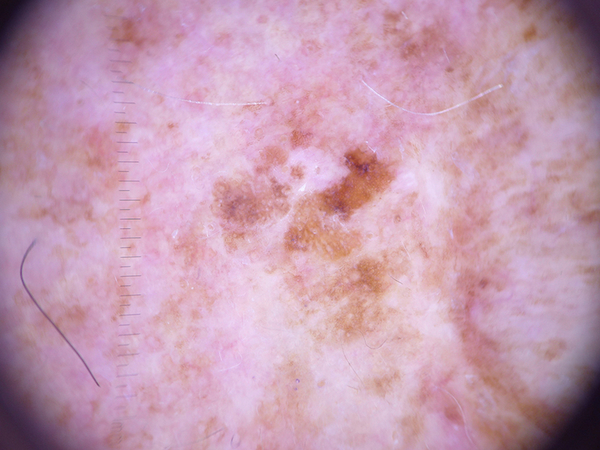

In [18]:
PIL.Image.open(dest_path+'/'+df['image_id'][1]+'.jpg')

In [19]:
print(df['dx'].unique())

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [20]:
print(df['dx_type'].unique())

['histo' 'consensus' 'confocal' 'follow_up']


## **Step 2** -> Data preprocessing :
---
Assumptions :

* Input : image ( numpy array )
* Ouput : categorical ( 0 - 6 )

In [21]:
df.drop(columns = ['lesion_id', 'dx_type', 'age', 'sex', 'localization'], inplace=True)

In [22]:
df

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


One hot encoding the type of disease :

In [23]:
df1 = pd.get_dummies(data=df, columns=['dx'])

In [24]:
dx_dict = {
    0 : 'akiec',
    1 : 'bcc',
    2 : 'bkl',
    3 : 'df',
    4 : 'mel',
    5 : 'nv',
    6 : 'vasc'
}

In [25]:
df1

,image_id,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc
0,ISIC_0027419,0,0,1,0,0,0,0
1,ISIC_0025030,0,0,1,0,0,0,0
2,ISIC_0026769,0,0,1,0,0,0,0
3,ISIC_0025661,0,0,1,0,0,0,0
4,ISIC_0031633,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
10010,ISIC_0033084,1,0,0,0,0,0,0
10011,ISIC_0033550,1,0,0,0,0,0,0
10012,ISIC_0033536,1,0,0,0,0,0,0
10013,ISIC_0032854,1,0,0,0,0,0,0


Image resizing : (180,180,3)

In [26]:
import cv2

In [27]:
X = []

for img in df['image_id']:
  image = cv2.imread('/content/images/'+img+'.jpg')
  resized_image = cv2.resize(image, (180,180))
  X.append(resized_image)

In [28]:
df2 = df1.drop(columns=['image_id'])
y = df2.to_numpy(copy=True)

In [29]:
X = np.array(X)

In [30]:
f'input shape : {X.shape}, output shape : {y.shape}'

'input shape : (10015, 180, 180, 3), output shape : (10015, 7)'

In [31]:
def plot_sample(X,y,index):
  plt.figure(figsize = (15,2))
  plt.imshow(X[index])
  plt.xlabel(dx_dict[np.argmax(y[index])])

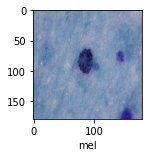

In [32]:
plot_sample(X,y,10014)

Training and test data set split 

* Train : 80%
* Test : 20%

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
memory_usage()

In [ ]:
import gc

del X
del y
del df
del df1
gc.collect()

1989

In [ ]:
memory_usage()

Scaling the images using the custom scaling function provided by keras

In [ ]:
memory_usage()

In [ ]:
del X_train
del X_test

gc.collect()

200

In [ ]:
memory_usage()

Data augmentation to improve accuracy

In [34]:
img_height, img_width = 180,180

data_augmentation = keras.Sequential(
    [
     keras.layers.experimental.preprocessing.RandomFlip('horizontal',
                                                        input_shape=(img_height,
                                                                     img_width,3)),
     keras.layers.experimental.preprocessing.RandomRotation(0.1),
     keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

In [35]:
X_train_scaled_efnetb7 = tf.keras.applications.efficientnet.preprocess_input(X_train)
X_test_scaled_efnetb7 = tf.keras.applications.efficientnet.preprocess_input(X_test)

## **Step 3** -> Designing the model
---
The deep learning model has two stages :


1.   CNN (from the pretrained model)
2.   ANN

* The CNN part is extracted from the pretrained model by removing the top layers.


> > The output of the CNN layer will be the feature map of the image.

* The input for the ANN will be the flattened feature map.
* ANN classifies the image into 7 categories





In [36]:
efNetB7_base_model = tf.keras.applications.EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_shape=(180,180,3),
    pooling='avg',
    classifier_activation="softmax",
)

efNetB7_base_model.trainable = False

efNetB7_model = keras.Sequential([
  data_augmentation,
  efNetB7_base_model,
  keras.layers.Flatten(),
  keras.layers.Dense(256, activation = 'relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(7, activation = 'softmax')                          
])

efNetB7_model.summary()

efNetB7_model.compile(
    optimizer = 'adam',
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

214212608/214201816 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)               

In [37]:
efNetB7_model.fit(X_train_scaled_efnetb7,y_train,batch_size=32,epochs = 25)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 51s 107ms/step - loss: 0.8529 - accuracy: 0.7044
Epoch 2/25
251/251 [==============================] - 27s 106ms/step - loss: 0.7540 - accuracy: 0.7254
Epoch 3/25
251/251 [==============================] - 27s 106ms/step - loss: 0.7078 - accuracy: 0.7413
Epoch 4/25
251/251 [==============================] - 27s 106ms/step - loss: 0.6788 - accuracy: 0.7515
Epoch 5/25
251/251 [==============================] - 27s 106ms/step - loss: 0.6565 - accuracy: 0.7650
Epoch 6/25
251/251 [==============================] - 27s 106ms/step - loss: 0.6384 - accuracy: 0.7651
Epoch 7/25
251/251 [==============================] - 27s 106ms/step - loss: 0.6268 - accuracy: 0.7722
Epoch 8/25
251/251 [==============================] - 27s 106ms/step - loss: 0.6064 - accuracy: 0.7773
Epoch 9/25
251/251 [==============================] - 27s 106ms/step - loss: 0.6001 - accuracy: 0.7756
Epoch 10/25
251/251 [==============================] - 27s 106ms/step - loss: 0.5894

In [38]:
efNetB7_base_model.trainable = True

efNetB7_model.summary()

efNetB7_model.compile(
    optimizer = 'adam',
    loss = keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                      

In [39]:
efNetB7_model.fit(X_train_scaled_efnetb7,y_train,batch_size=32,epochs = 25)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


251/251 [==============================] - 115s 356ms/step - loss: 0.9058 - accuracy: 0.7099
Epoch 2/25
251/251 [==============================] - 89s 355ms/step - loss: 0.6165 - accuracy: 0.7753
Epoch 3/25
251/251 [==============================] - 89s 355ms/step - loss: 0.5346 - accuracy: 0.8077
Epoch 4/25
251/251 [==============================] - 89s 355ms/step - loss: 0.4910 - accuracy: 0.8209
Epoch 5/25
251/251 [==============================] - 89s 355ms/step - loss: 0.4533 - accuracy: 0.8386
Epoch 6/25
251/251 [==============================] - 89s 355ms/step - loss: 0.4359 - accuracy: 0.8459
Epoch 7/25
251/251 [==============================] - 89s 355ms/step - loss: 0.4028 - accuracy: 0.8561
Epoch 8/25
251/251 [==============================] - 89s 355ms/step - loss: 0.3877 - accuracy: 0.8586
Epoch 9/25
251/251 [==============================] - 89s 355ms/step - loss: 0.3722 - accuracy: 0.8635
Epoch 10/25
251/251 [==============================] - 89s 355ms/step - loss: 0.391

In [40]:
efNetB7_model.evaluate(X_test_scaled_efnetb7, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 10s 106ms/step - loss: 0.6052 - accuracy: 0.8228


[0.6052021384239197, 0.8227658271789551]

In [41]:
save_path = '/content/classification_model.h5'
efNetB7_model.save(save_path)

In [42]:
b7_predictions = efNetB7_model.predict(X_test_scaled_efnetb7)

In [43]:
b7_categorical_predictions = [np.argmax(ele) for ele in b7_predictions]

In [45]:
categorical_test = [np.argmax(ele) for ele in y_test]

In [47]:
print(f'true      : {categorical_test[:20]} \npredicted : {b7_categorical_predictions[:20]}')

true      : [5, 5, 5, 5, 1, 4, 5, 5, 1, 5, 5, 2, 2, 5, 4, 2, 5, 5, 2, 5] 
predicted : [5, 5, 5, 5, 2, 2, 5, 5, 1, 5, 5, 2, 2, 5, 5, 2, 2, 5, 2, 5]


In [48]:
from sklearn.metrics import classification_report

print('classification report of EfficientNet B7 with custom ANN :')
print(f'{classification_report(categorical_test, b7_categorical_predictions)}')

classification report of EfficientNet B7 with custom ANN :
              precision    recall  f1-score   support

           0       0.90      0.31      0.46        61
           1       0.70      0.79      0.75       111
           2       0.60      0.75      0.67       198
           3       0.78      0.62      0.69        29
           4       0.54      0.64      0.58       223
           5       0.93      0.89      0.91      1351
           6       1.00      0.77      0.87        30

    accuracy                           0.82      2003
   macro avg       0.78      0.68      0.70      2003
weighted avg       0.84      0.82      0.82      2003



# **Report** :
(EfficientNetB7)

---

Accuracy :

* 92.79% for training set
* ~83% for test set

> * Overfitting is more
> * It is also observed that overfitting increased as the number of epochs increased.

## Observations :

### Image 1 : Basal Cell Carcenoma (BCC)

In [97]:
test_image = cv2.imread('/content/bcc2.jpg')
resized_image = cv2.resize(test_image, (180,180))

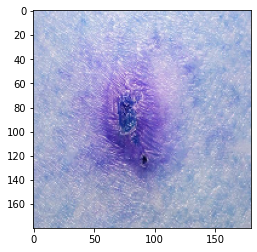

In [99]:
plt.imshow(resized_image)

In [100]:
X_Pred = []
X_Pred.append(resized_image)
X_Pred = np.array(X_Pred)

In [103]:
X_Pred = tf.keras.applications.efficientnet.preprocess_input(X_Pred)

In [104]:
X_Pred.shape

(1, 180, 180, 3)

In [105]:
pred_value = efNetB7_model.predict(X_Pred)

In [106]:
pred_value

array([[1.2313445e-04, 9.9336523e-01, 5.6248455e-04, 6.0712511e-04,
        2.7104915e-04, 4.6043722e-03, 4.6653007e-04]], dtype=float32)

In [108]:
categorical_pred = np.argmax(pred_value[0])
predicted = dx_dict[categorical_pred]
predicted

'bcc'

### Image 2 : Benign Keratosis (BKL)

In [141]:
test_image = cv2.imread('/content/benign_keratosis.jpg')
resized_image = cv2.resize(test_image, (180,180))

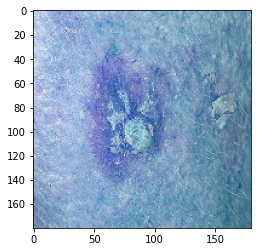

In [142]:
plt.imshow(resized_image)

In [143]:
X_Pred = []
X_Pred.append(resized_image)
X_Pred = np.array(X_Pred)

In [144]:
X_Pred = tf.keras.applications.efficientnet.preprocess_input(X_Pred)

In [145]:
X_Pred.shape

(1, 180, 180, 3)

In [146]:
pred_value = efNetB7_model.predict(X_Pred)

In [147]:
pred_value

array([[0.31757325, 0.08477398, 0.3444564 , 0.00056499, 0.00342856,
        0.24870896, 0.00049391]], dtype=float32)

In [148]:
categorical_pred = np.argmax(pred_value[0])
predicted = dx_dict[categorical_pred]
predicted

'bkl'

### Image 3 : Melanocytic Nevi (NV)

In [173]:
test_image = cv2.imread('/content/nv1.jfif')
resized_image = cv2.resize(test_image, (180,180))

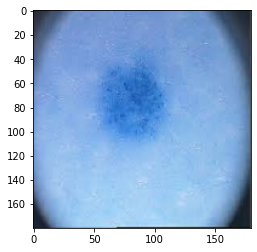

In [174]:
plt.imshow(resized_image)

In [175]:
X_Pred = []
X_Pred.append(resized_image)
X_Pred = np.array(X_Pred)

In [176]:
X_Pred = tf.keras.applications.efficientnet.preprocess_input(X_Pred)

In [177]:
X_Pred.shape

(1, 180, 180, 3)

In [178]:
pred_value = efNetB7_model.predict(X_Pred)

In [179]:
pred_value

array([[7.4008437e-07, 9.3362423e-06, 1.3854698e-04, 1.5744725e-06,
        6.7275716e-05, 9.9977225e-01, 1.0334672e-05]], dtype=float32)

In [180]:
categorical_pred = np.argmax(pred_value[0])
predicted = dx_dict[categorical_pred]
predicted

'nv'

### Image 4 : Melanoma (MEL)

In [197]:
test_image = cv2.imread('/content/melanoma_img.jpg')
resized_image = cv2.resize(test_image, (180,180))

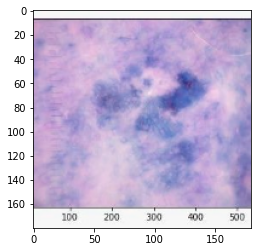

In [198]:
plt.imshow(resized_image)

In [199]:
X_Pred = []
X_Pred.append(resized_image)
X_Pred = np.array(X_Pred)

In [200]:
X_Pred = tf.keras.applications.efficientnet.preprocess_input(X_Pred)

In [201]:
X_Pred.shape

(1, 180, 180, 3)

In [202]:
pred_value = efNetB7_model.predict(X_Pred)

In [203]:
pred_value

array([[2.9383812e-02, 4.2062085e-03, 9.1070724e-01, 1.6355657e-04,
        9.4980933e-03, 4.6015002e-02, 2.6065236e-05]], dtype=float32)

In [204]:
categorical_pred = np.argmax(pred_value[0])
predicted = dx_dict[categorical_pred]
predicted

'bkl'

### Image 5 : Normal Skin (-)
> * It is observed that normal skin is classified as 'nv' i.e. Melanocytic Nevi.
> * Melanocytic Nevi is just a non-cancerous dark spot on the skin

In [189]:
test_image = cv2.imread('/content/normal1.jfif')
resized_image = cv2.resize(test_image, (180,180))

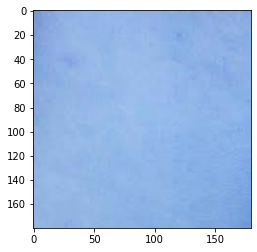

In [190]:
plt.imshow(resized_image)

In [191]:
X_Pred = []
X_Pred.append(resized_image)
X_Pred = np.array(X_Pred)

In [192]:
X_Pred = tf.keras.applications.efficientnet.preprocess_input(X_Pred)

In [193]:
X_Pred.shape

(1, 180, 180, 3)

In [194]:
pred_value = efNetB7_model.predict(X_Pred)

In [195]:
pred_value

array([[7.4614033e-02, 1.7962232e-02, 1.1185765e-01, 7.9309344e-03,
        9.7560436e-03, 7.7739435e-01, 4.8474816e-04]], dtype=float32)

In [196]:
categorical_pred = np.argmax(pred_value[0])
predicted = dx_dict[categorical_pred]
predicted

'nv'